# Bootcomp  - selection of top m of k simulated systems

This Jupyter _Python 3_ notebook has been written to accompany the WSC18 paper:

**PRACTICAL CONSIDERATIONS IN SELECTING THE BEST SET OF SIMULATED SYSTEMS**  _by Christine Currie and Tom Monks.

The notebook provides a worked example of using BootComp to conduct a 2 stage screening and search of a simulation model.    It is a simple example that does not consider chance constraints.  Note that Bootcomp would typically be used in a multiple KPI situation.



## 1. Preamble

### 1.1. Detail of the simulation model

The simulation model was used in a 2017 project in the UK to help a hospital, a community healthcare provider and a clinical commissioning group design and plan a new community rehabilitation ward.  In the UK, patients who require rehabilitation are often stuck in a queuing system where there must wait (inappropriately) in a acute hospital bed for a space in the rehabilitaiton ward.  The model investigated the sizing of the new ward in order to minimise patient waiting time whilst meeting probabilitic constraints regarding ward occupancy (bed utilization) and the number of transfers between single sex bays.

<img src="images/DToC.jpg" alt="Delayed Transfers of Care Model" title="Simulation Model and KPIs" />

### 1.2. Output data

The output data for the example analysis are bundled with git repository.  There are three .csv files in the data/ directory for 'waiting times', 'utilization' and 'transfers'.  

The model itself is not needed.  There are 50 replications of 1151 competing designs points.  Users can vary the number of replications used in the two stage procedure.  

The experimental design is also included for reference.

## 2. Prerequisites

### 2.1. BootComp Modules

In [1]:
import Bootstrap as bs
import BootIO as io
import ConvFuncs as cf

In [2]:
#WSC18 specific
import Bootstrap_crn as crn
from Bootstrap_crn import bootstrap_chance_constraint

### 2.2. Python Data Science Modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats
%matplotlib inline
import matplotlib as mp
import seaborn as sns
from numba import jit

## 3. Procedure: Stage 1

** Optimization Parameters **

N_BOOTS = no. bootstraps to perform

** Stage 1 **

$n_1$ = no. stage 1 indeptendent replications for each systems / competing design

$p_1$ = percentage of bootstrap samples that must meet chance constraint in stage 1

$y_1$ proportion of bootstrap samples of primary KPI that must be within $x_1$ percent of the best system

** Stage 2 **

$n_2$ = no. stage 2 independent replications for each system / competigin design

$p_1$ = percentage of bootstrap samples that must meet chance constraint in stage 2

$y_1$ proportion of bootstrap samples of primary KPI that must be within $x_1$ percent of the best system in stage 2

In [4]:
N_BOOTS = 1000
m = 3
n_1 = 20
n_2 = 480

budget = 2000 # total number of replications

gamma_1 = 0.95  # not relevant with no chance contraints
x_1 = 0.5 
y_1 = 0.8

x1_limits = np.linspace(0.4,0.1,4)#.arange(0.05, 0.5, 0.05)


gamma_2 = 0.95  # not relevant with no chance contraints
x_2 = 0.3
y_2 = 0.90

y1_limits = np.linspace(0.6,0.95,8)#np.arange(0.8, 0.95, 0.05)

print(x1_limits)
print(y1_limits)


[0.4 0.3 0.2 0.1]
[0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]


In [5]:
def simulate(file_name, reps):
    return crn.load_systems(file_name, exclude_reps = 10000-reps)
    

In [6]:
def simulate_experiment(model, reps, systems):
    return model[:,:reps][systems]
    

### Step 1: Read in initial $ n_1 $  replications

In [7]:
model_file = "data/EG1a.csv"

In [8]:
def indifferent(x, indifference):
    """
    convert numbers to 0 or 1
    1 = difference less than x
    0 = difference greater than x
    """
    if x > 0:
        return 1
    elif abs(x)<= indifference:
        return 1
    else:
        return 0
    

def stage1_output(diffs, x_1, y_1, systems, best_system_index, nboots):
    indifference = systems[best_system_index].mean() * x_1
    df_indifference = diffs.applymap(lambda x: indifferent(x, indifference))
    #print('x: {0}; y:{1}'.format(x_1, y_1))
    
    #if(x_1 == 0.1 and y_1 >= 0.94):
    #    print(diffs)
    #    print(df_indifference)
    threshold = nboots * y_1
    df_within_limit = df_indifference.sum(0)
    df_within_limit= pd.DataFrame(df_within_limit, columns=['sum'])
    return df_within_limit.loc[df_within_limit['sum'] >= threshold].index


def bootcomp_run(systems, xlimits, ylimits, nboots, k, m, labels):
    df_wait = pd.DataFrame(systems)
    
    args =  bs.BootstrapArguments()

    args.nboots = nboots
    args.nscenarios = k
    args.point_estimate_func = bs.bootstrap_mean
    
    subset_waits = df_wait.mean()
    subset_waits.rename('wait', inplace=True)
    
    subset_kpi = pd.concat([subset_waits], axis=1)
    best_system_index = subset_kpi.sort_values(by=['wait'], ascending=False).index[0]
    
    feasible_systems = df_wait
    
    #edited here (added .mean())
    diffs =  pd.DataFrame(feasible_systems.values.T - np.array(feasible_systems[best_system_index]).mean()).T
    diffs[best_system_index] = 0
    #print(diffs)                     
    resample_diffs = bs.resample_all_scenarios(diffs.values.T.tolist(), args)
    
    df_boots_diffs= cf.resamples_to_df(resample_diffs, nboots)
    df_boots_diffs.columns = labels

    optim = []

    for x in xlimits:
        for y in ylimits:
            optim.append([x, y, stage1_output(df_boots_diffs, x, y, feasible_systems, best_system_index, nboots).values])
    
    return pd.DataFrame(optim, columns = ['x1', 'y1', 's1 output'])

In [18]:
def test_bootcomp(budget, model, m, k, n = 20, nboots=1000):
    #stage 1
    
    select_systems = [i for i in range(k)]
    data = simulate_experiment(model = model, reps = n, systems = select_systems)
    

    results = bootcomp_run(data.T, x1_limits, y1_limits, nboots, k, m, select_systems)
    #print(results)
    take_forward = crn.auto_select_parameters(results)
    print(take_forward)
    #stage 2
    #equal allocation of remaining budget
    stage2_replicates = int((budget - (n * k))/len(take_forward)) + n
    print("stage 2 {0}".format(stage2_replicates))
    data = simulate_experiment(model = model, reps = stage2_replicates, systems = (take_forward - 1).tolist())
    k = data.shape[0]
    print(data.mean(axis=1))
    
    results = bootcomp_run(data.T, x1_limits, y1_limits, N_BOOTS, k, m, take_forward.tolist())
    #print(results)
    return auto_select_top_m(results, m)

In [10]:
@jit(nopython=True)
def bootstrap(data, boots=1000):
    """
       
    Returns a numpy array containing the bootstrap resamples
    Useful for creating a large number of experimental datasets for testing R&S routines
    
    @data = numpy.array of systems to boostrap
    @boots = number of bootstrap (default = 1000)
    """

    experiments = boots
    designs = 10
    samples = data.shape[1]

    datasets = np.zeros((experiments, designs, samples))
     
    for exp in range(experiments):
        
        for design in range(designs):

            for i in range(samples):

                datasets[exp][design][i] = data[design][round(np.random.uniform(0, samples)-1)]
      
    return datasets

In [11]:
def cs(selected_top_m, true_top_m):
    """
    Returns boolean value.  
    True = correct selection of top m
    False = incorrect selection (one or more of selected top m is incorrect)
    
    @selected_top_m - numpy.array containing the indexes of the top m means selected by the algorithm
    @true_top_m - numpy.array containing the indexes of the true top m means
    
    """
    return np.array_equal(np.sort(selected_top_m), true_top_m)

In [56]:
def oc(true_means, selected_top_m, true_top_m):
    """
    Return the opportunity cost of the selection
    Method penalised particular bad solutions more than mildly bad
    
    @true_means - numpy.array of true means
    @selected_top_m - numpy.array containing the indexes of the top m means selected by the algorithm
    @true_top_m - numpy.array containing the indexes of the true top m means
    
    """
    return true_means[true_top_m].sum() - true_means[selected_top_m].sum()


In [55]:
true_means = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
selected_top_m = [2, 3, 4]
true_top_m = [7, 8, 9]

oc(true_means, selected_top_m, true_top_m)

15

# Create Experimental Data

In [59]:
data = np.genfromtxt(model_file, delimiter=",", skip_footer=0).transpose()
experiments = bootstrap(data, boots = 10)
true_top_m = [7, 8, 9]
T = 3000
budgets = [i for i in range(1000, T + 200, 200)]

In [79]:
def auto_select_top_m(results_stage2, m):
    df = results_stage2
    df['length'] = df['s1 output'].str.len()
    df_m = df.loc[df['length'] == m]
    
    if(df_m.shape[0] == 0):
        df_m = df.loc[df['length'] > m]
        
        if(df_m.shape[0] == 0):
            df_m = df.loc[df['length'] == m - 1]
           
        
    

    try:
        result = df_m[-1:]['s1 output'].values[0][-m:]
    except IndexError:
        #result = np.array([0,0,0])
        #print(df_m)
        result = df_m[-1:]['s1 output'].values[0]
    finally:
        return result


In [17]:
pd.DataFrame(experiments[1]).T[:20].to_clipboard(excel=True)

In [104]:
x = test_bootcomp(budget=2000, model=experiments[0], n = 20, m=3, k=10, nboots = 1000)
print(x)

[7 8 9]
stage 2 620
[6.66185766 8.21196893 8.96200632]
[7 8 9]


In [110]:
def numerical_experiment(experiments, budgets, m, n_0, true_means, nboots=1000):
    """
    Conduct a user set number of numerical experiments on the algorithm
    for different computational budgets
    
    Returns:
    1. numpy.array containing P{cs} for each budget
        
    @experiments numpy.array[experiments][designs][replication]
    @budgets python.list containing budgets
    @model_file string path to model 
    
    """
    
    n_experiments = experiments.shape[0]
    k = experiments.shape[1]
    
    correct_selections = np.zeros((n_experiments, len(budgets)))
   
    for exp in range(n_experiments):

        for t in range(len(budgets)):
            #print(experiments[exp].shape)
            #try:
            selected_top_m = test_bootcomp(budget=budgets[t], model=experiments[exp],m=m, k=k, n=n_0, nboots=nboots).tolist()
            #selected_top_m = selected_top_m[0]
            print(selected_top_m)
            correct_selections[exp][t] = oc(true_means, selected_top_m, true_top_m)
            #except:
            #    correct_selections[exp][t] = 0
            
            

    return correct_selections
    

note: could do proportional allocation for stage 1 and 2.
e.g. budget = 1000 with 

In [37]:
budgets

[1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000]

In [111]:
css = numerical_experiment(experiments, budgets, 3, 20, true_means)

[7 8 9]
stage 2 286
[6.2825464  7.9812599  9.09133596]
[7, 8, 9]
[7 8 9]
stage 2 353
[6.43645178 7.91054653 8.97795732]
[7, 8, 9]
[7 8 9]
stage 2 420
[6.48460468 8.0428765  9.00445956]
[7, 8, 9]
[7 8 9]
stage 2 486
[6.65021563 8.03941613 9.07474083]
[7, 8, 9]
[7 8 9]
stage 2 553
[6.67606667 7.97220374 8.98374921]
[7, 8, 9]
[7 8 9]
stage 2 620
[6.66185766 8.21196893 8.96200632]
[7, 8, 9]
[7 8 9]
stage 2 686
[6.78098134 8.11340776 8.94394962]
[7, 8, 9]
[7 8 9]
stage 2 753
[6.78274452 8.17742643 8.916731  ]
[7, 8, 9]
[7 8 9]
stage 2 820
[6.76141714 8.14475646 8.89683329]
[7, 8, 9]
[7 8 9]
stage 2 886
[6.74361739 8.12576678 8.86723074]
[7, 8, 9]
[7 8 9]
stage 2 953
[6.7912009  8.10463527 8.90702842]
[7, 8, 9]
[7 8 9]
stage 2 286
[7.18500882 8.35656935 8.38595698]
[7, 8, 9]
[7 8 9]
stage 2 353
[7.03341221 8.13229302 8.65907103]
[7, 8, 9]
[7 8 9]
stage 2 420
[7.00618449 7.93573318 8.60863137]
[7, 8, 9]
[7 8 9]
stage 2 486
[6.94645981 7.76314201 8.67220875]
[7, 8, 9]
[7 8 9]
stage 2 553
[6.99

In [112]:
pd.DataFrame(css)

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[]

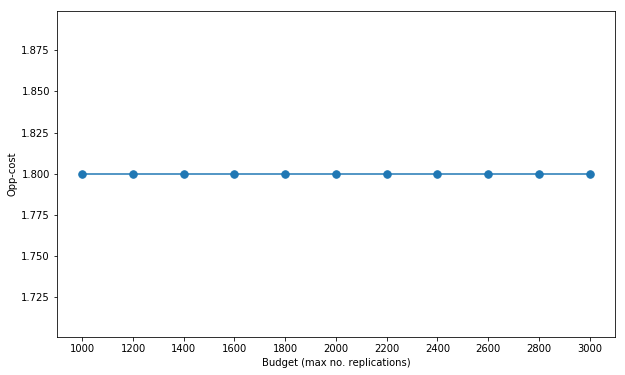

In [113]:
fig = plt.figure(figsize=(10,6))
ax = pd.DataFrame(css, columns=budgets).mean(axis=0).plot(style='.-', ms=15)
ax.set_ylabel("Opp-cost")
ax.set_xlabel("Budget (max no. replications)")
ax.set_xticks(ticks = [i for i in range(200, 8000, 200)])

ax.plot()